<a href="https://colab.research.google.com/github/fazekas-gergo/composer-ai/blob/master/ComposerAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composer AI
Authors: Fazekas Gergő and Joseph Tadrous<br>
Used dataset: https://www.kaggle.com/soumikrakshit/classical-music-midi

---
## 1. First steps
At first clone the repository (which also contains the dataset) and install the required packages.

In [ ]:
!git clone -l -s https://github.com/fazekas-gergo/composer-ai composer-ai
%cd composer-ai
!pip install midi2audio
!pip install py_midicsv
!pip install pretty_midi
!sudo apt-get install fluidsynth

---
## 2. Data Familiarization
The *convert_midi_to_flac* function is able to convert the midi file to be listenable by a soundfont file.

In [51]:
from midi2audio import FluidSynth
from IPython.display import Audio

def convert_midi_to_flac(music_path, output='music'):
  FluidSynth('piano.sf2').midi_to_audio(music_path, 'music' + '.flac')

convert_midi_to_flac('classical_music_midi/albeniz/alb_esp1.mid', output='music')
Audio('music.flac')

The *music21* package lets us to plot the midi file.

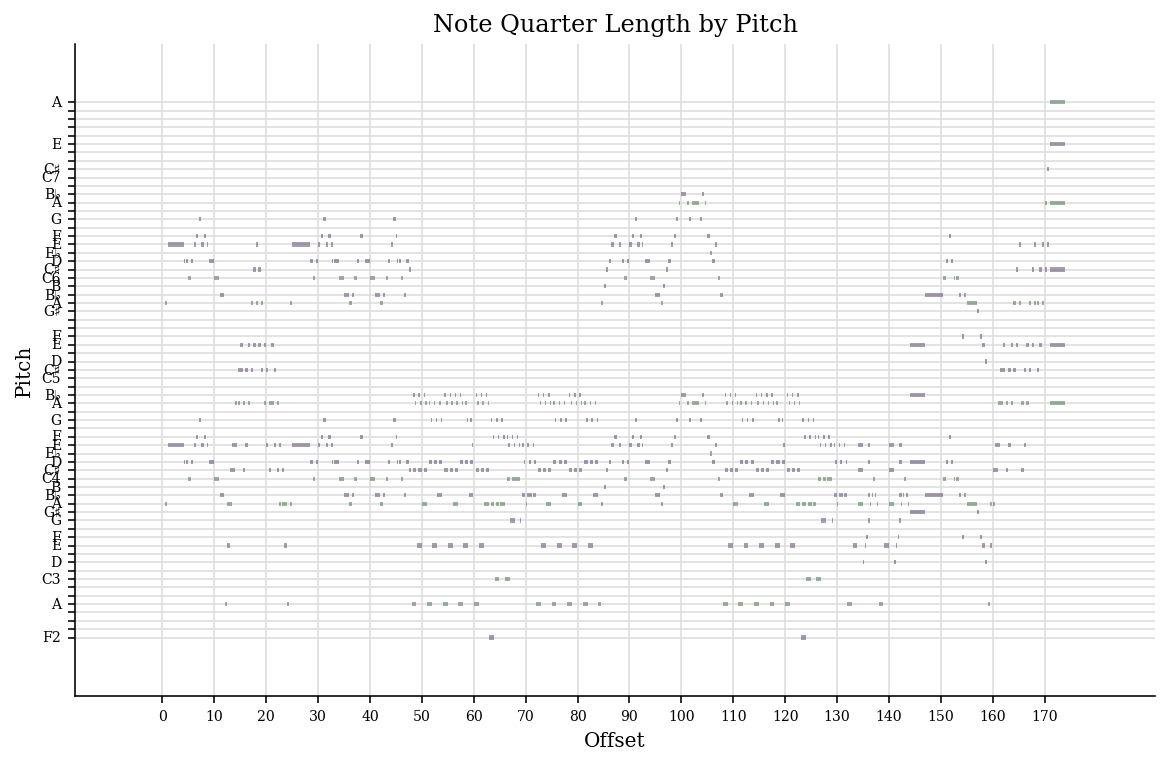

In [52]:
import music21

music = music21.converter.parse('classical_music_midi/albeniz/alb_esp1.mid')
music.plot()

---
## 3. Data preparation
At first let's create a list, which contains all the midi files from the dataset.

In [53]:
import os

def get_midi_files(main_folder):
  files = []
  for dir in os.listdir(main_folder):
    for file in os.listdir(main_folder + os.path.sep + dir):
      files.append(main_folder + os.path.sep + dir + os.path.sep + file)
  return files

midi_files = get_midi_files('classical_music_midi')
print('Number of read MIDI files:', len(midi_files))

Number of read MIDI files: 295


Secondly, create a pandas data frame filled with the pitches and durations of the notes sorted by the start time.<br>

In [56]:
import pretty_midi
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def instrument_to_df(instrument):
    notes = collections.defaultdict(list)
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def midi_file_to_df(midi_file):
  m = pretty_midi.PrettyMIDI(midi_file)
  return pd.concat([instrument_to_df(instrument) for instrument in m.instruments])

def midi_files_to_df(midi_files):
  return pd.concat([midi_file_to_df(f) for f in midi_files])

df = midi_files_to_df(midi_files)
df

,pitch,step,duration
0,74,0.000000,0.250000
1,79,0.250000,0.083333
2,74,0.083333,0.352941
3,71,0.352941,0.250000
4,74,0.250000,0.083333
...,...,...,...
347,52,0.382166,1.576334
348,28,1.576334,0.890648
349,40,0.890648,3.207794
350,47,0.123301,3.084493


In [54]:
df.describe()

,pitch,step,duration
count,710084.000000,710084.000000,710084.000000
mean,64.374204,0.207139,0.299385
std,13.408115,1.092787,0.409050
min,21.000000,0.000000,0.000781
25%,55.000000,0.000000,0.102975
50%,65.000000,0.117647,0.161264
75%,74.000000,0.239044,0.333333
max,107.000000,756.058915,20.371013


Finally, the definition of the **X** (features) and **Y** (targets) matrixes.<br>
The modell has to guess the next note's parameters, therefore we need to shift the **X** matrix with one step.

In [59]:
X, Y = df, df.shift(fill_value=0)
X, Y

(     pitch      step  duration
 0       74  0.000000  0.250000
 1       79  0.250000  0.083333
 2       74  0.083333  0.352941
 3       71  0.352941  0.250000
 4       74  0.250000  0.083333
 ..     ...       ...       ...
 347     52  0.382166  1.576334
 348     28  1.576334  0.890648
 349     40  0.890648  3.207794
 350     47  0.123301  3.084493
 351     56  0.129336  2.955157
 
 [710084 rows x 3 columns],      pitch      step  duration
 0        0  0.000000  0.000000
 1       74  0.000000  0.250000
 2       79  0.250000  0.083333
 3       74  0.083333  0.352941
 4       71  0.352941  0.250000
 ..     ...       ...       ...
 347     59  0.382165  1.958500
 348     52  0.382166  1.576334
 349     28  1.576334  0.890648
 350     40  0.890648  3.207794
 351     47  0.123301  3.084493
 
 [710084 rows x 3 columns])